# Bayesian Inference with Markov Chain Monte Carlo (MCMC)

## Introduction

Bayesian inference provides a principled framework for updating our beliefs about unknown parameters in light of observed data. Unlike frequentist approaches that treat parameters as fixed but unknown quantities, Bayesian inference treats parameters as random variables with associated probability distributions.

## Theoretical Foundation

### Bayes' Theorem

The cornerstone of Bayesian inference is **Bayes' theorem**, which relates the posterior distribution to the prior and likelihood:

$$P(\theta | D) = \frac{P(D | \theta) \cdot P(\theta)}{P(D)}$$

where:
- $P(\theta | D)$ is the **posterior distribution** — our updated belief about parameter $\theta$ after observing data $D$
- $P(D | \theta)$ is the **likelihood** — the probability of observing the data given the parameter
- $P(\theta)$ is the **prior distribution** — our initial belief about the parameter before seeing data
- $P(D) = \int P(D | \theta) P(\theta) d\theta$ is the **marginal likelihood** or **evidence**

### The Computational Challenge

The marginal likelihood $P(D)$ often involves intractable integrals, especially in high-dimensional parameter spaces:

$$P(D) = \int_{\Theta} P(D | \theta) P(\theta) d\theta$$

This is where **Markov Chain Monte Carlo (MCMC)** methods become essential — they allow us to sample from the posterior distribution without explicitly computing the normalizing constant.

## MCMC: The Metropolis-Hastings Algorithm

### Core Idea

MCMC constructs a Markov chain whose stationary distribution is the target posterior distribution $\pi(\theta) = P(\theta | D)$. The **Metropolis-Hastings algorithm** is a general-purpose MCMC method.

### Algorithm

Given current state $\theta_t$:

1. **Propose** a candidate state $\theta^*$ from proposal distribution $q(\theta^* | \theta_t)$

2. **Compute** the acceptance probability:
   $$\alpha = \min\left(1, \frac{\pi(\theta^*) q(\theta_t | \theta^*)}{\pi(\theta_t) q(\theta^* | \theta_t)}\right)$$

3. **Accept or Reject**:
   - Draw $u \sim \text{Uniform}(0, 1)$
   - If $u < \alpha$, set $\theta_{t+1} = \theta^*$ (accept)
   - Otherwise, set $\theta_{t+1} = \theta_t$ (reject)

### Random Walk Metropolis

A common choice is the symmetric random walk proposal:

$$\theta^* = \theta_t + \epsilon, \quad \epsilon \sim \mathcal{N}(0, \sigma^2)$$

Since $q(\theta^* | \theta_t) = q(\theta_t | \theta^*)$, the acceptance ratio simplifies to:

$$\alpha = \min\left(1, \frac{\pi(\theta^*)}{\pi(\theta_t)}\right)$$

### Convergence Properties

Under mild regularity conditions, the Markov chain satisfies:
- **Irreducibility**: Any state can be reached from any other state
- **Aperiodicity**: The chain does not cycle deterministically
- **Ergodicity**: Time averages converge to ensemble averages

$$\lim_{N \to \infty} \frac{1}{N} \sum_{t=1}^{N} f(\theta_t) = \mathbb{E}_{\pi}[f(\theta)]$$

## Practical Example: Inferring Parameters of a Normal Distribution

We will demonstrate Bayesian inference by estimating the mean $\mu$ and standard deviation $\sigma$ of a normal distribution from observed data.

### Model Specification

**Likelihood:**
$$X_i | \mu, \sigma \sim \mathcal{N}(\mu, \sigma^2), \quad i = 1, \ldots, n$$

**Priors:**
$$\mu \sim \mathcal{N}(\mu_0, \tau_0^2)$$
$$\sigma \sim \text{Half-Normal}(s)$$

**Joint Likelihood:**
$$P(D | \mu, \sigma) = \prod_{i=1}^{n} \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x_i - \mu)^2}{2\sigma^2}\right)$$

**Log-posterior (up to a constant):**
$$\log P(\mu, \sigma | D) \propto -\frac{n}{2}\log(\sigma^2) - \frac{1}{2\sigma^2}\sum_{i=1}^{n}(x_i - \mu)^2 - \frac{(\mu - \mu_0)^2}{2\tau_0^2} - \frac{\sigma^2}{2s^2}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic observed data
true_mu = 5.0
true_sigma = 2.0
n_observations = 100

data = np.random.normal(true_mu, true_sigma, n_observations)

print(f"True parameters: μ = {true_mu}, σ = {true_sigma}")
print(f"Sample mean: {data.mean():.3f}")
print(f"Sample std: {data.std():.3f}")
print(f"Number of observations: {n_observations}")

True parameters: μ = 5.0, σ = 2.0
Sample mean: 4.792
Sample std: 1.807
Number of observations: 100


In [2]:
# Prior hyperparameters
mu_0 = 0.0       # Prior mean for μ
tau_0 = 10.0     # Prior std for μ (weakly informative)
s = 10.0         # Scale for half-normal prior on σ

def log_prior(mu, sigma):
    """
    Compute log of the prior distribution.
    Prior on μ: Normal(mu_0, tau_0^2)
    Prior on σ: Half-Normal(s) - only positive values
    """
    if sigma <= 0:
        return -np.inf
    
    # Log prior for mu (Normal)
    log_prior_mu = -0.5 * ((mu - mu_0) / tau_0) ** 2
    
    # Log prior for sigma (Half-Normal)
    log_prior_sigma = -0.5 * (sigma / s) ** 2
    
    return log_prior_mu + log_prior_sigma

def log_likelihood(mu, sigma, data):
    """
    Compute log-likelihood for Normal distribution.
    """
    if sigma <= 0:
        return -np.inf
    
    n = len(data)
    residuals = data - mu
    
    ll = -n * np.log(sigma) - 0.5 * np.sum(residuals**2) / sigma**2
    return ll

def log_posterior(mu, sigma, data):
    """
    Compute unnormalized log-posterior.
    """
    lp = log_prior(mu, sigma)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(mu, sigma, data)

print("Log-posterior functions defined.")

Log-posterior functions defined.


In [3]:
def metropolis_hastings(log_posterior_fn, data, initial_params, 
                        n_iterations, proposal_std):
    """
    Metropolis-Hastings MCMC sampler for 2D parameter space.
    
    Parameters:
    -----------
    log_posterior_fn : callable
        Function that computes log-posterior given (mu, sigma, data)
    data : array-like
        Observed data
    initial_params : tuple
        Starting values (mu_init, sigma_init)
    n_iterations : int
        Number of MCMC iterations
    proposal_std : tuple
        Standard deviations for proposals (std_mu, std_sigma)
    
    Returns:
    --------
    samples : ndarray of shape (n_iterations, 2)
        MCMC samples [mu, sigma]
    acceptance_rate : float
        Fraction of accepted proposals
    """
    mu_current, sigma_current = initial_params
    std_mu, std_sigma = proposal_std
    
    samples = np.zeros((n_iterations, 2))
    n_accepted = 0
    
    current_log_post = log_posterior_fn(mu_current, sigma_current, data)
    
    for i in range(n_iterations):
        # Propose new parameters (random walk)
        mu_proposed = mu_current + np.random.normal(0, std_mu)
        sigma_proposed = sigma_current + np.random.normal(0, std_sigma)
        
        # Compute log-posterior for proposed parameters
        proposed_log_post = log_posterior_fn(mu_proposed, sigma_proposed, data)
        
        # Compute acceptance probability (in log space)
        log_alpha = proposed_log_post - current_log_post
        
        # Accept or reject
        if np.log(np.random.random()) < log_alpha:
            mu_current = mu_proposed
            sigma_current = sigma_proposed
            current_log_post = proposed_log_post
            n_accepted += 1
        
        samples[i] = [mu_current, sigma_current]
    
    acceptance_rate = n_accepted / n_iterations
    return samples, acceptance_rate

print("Metropolis-Hastings sampler implemented.")

Metropolis-Hastings sampler implemented.


In [4]:
# MCMC Configuration
n_iterations = 50000
burn_in = 10000
initial_params = (0.0, 1.0)  # Starting values
proposal_std = (0.2, 0.1)    # Proposal standard deviations

print(f"Running Metropolis-Hastings with {n_iterations} iterations...")
print(f"Burn-in period: {burn_in}")
print(f"Initial parameters: μ = {initial_params[0]}, σ = {initial_params[1]}")
print(f"Proposal std: μ ~ N(0, {proposal_std[0]}), σ ~ N(0, {proposal_std[1]})")

# Run MCMC
samples, acceptance_rate = metropolis_hastings(
    log_posterior, data, initial_params, n_iterations, proposal_std
)

print(f"\nAcceptance rate: {acceptance_rate:.3f}")
print("(Optimal acceptance rate for 2D: ~0.234)")

Running Metropolis-Hastings with 50000 iterations...
Burn-in period: 10000
Initial parameters: μ = 0.0, σ = 1.0
Proposal std: μ ~ N(0, 0.2), σ ~ N(0, 0.1)



Acceptance rate: 0.575
(Optimal acceptance rate for 2D: ~0.234)


In [5]:
# Discard burn-in samples
samples_post_burnin = samples[burn_in:]

mu_samples = samples_post_burnin[:, 0]
sigma_samples = samples_post_burnin[:, 1]

# Compute posterior statistics
mu_mean = np.mean(mu_samples)
mu_std = np.std(mu_samples)
mu_ci = np.percentile(mu_samples, [2.5, 97.5])

sigma_mean = np.mean(sigma_samples)
sigma_std = np.std(sigma_samples)
sigma_ci = np.percentile(sigma_samples, [2.5, 97.5])

print("Posterior Summary Statistics")
print("=" * 50)
print(f"\nParameter μ:")
print(f"  Posterior mean: {mu_mean:.4f}")
print(f"  Posterior std:  {mu_std:.4f}")
print(f"  95% CI: [{mu_ci[0]:.4f}, {mu_ci[1]:.4f}]")
print(f"  True value: {true_mu}")

print(f"\nParameter σ:")
print(f"  Posterior mean: {sigma_mean:.4f}")
print(f"  Posterior std:  {sigma_std:.4f}")
print(f"  95% CI: [{sigma_ci[0]:.4f}, {sigma_ci[1]:.4f}]")
print(f"  True value: {true_sigma}")

Posterior Summary Statistics

Parameter μ:
  Posterior mean: 4.7905
  Posterior std:  0.1818
  95% CI: [4.4404, 5.1465]
  True value: 5.0

Parameter σ:
  Posterior mean: 1.8350
  Posterior std:  0.1322
  95% CI: [1.6004, 2.1130]
  True value: 2.0


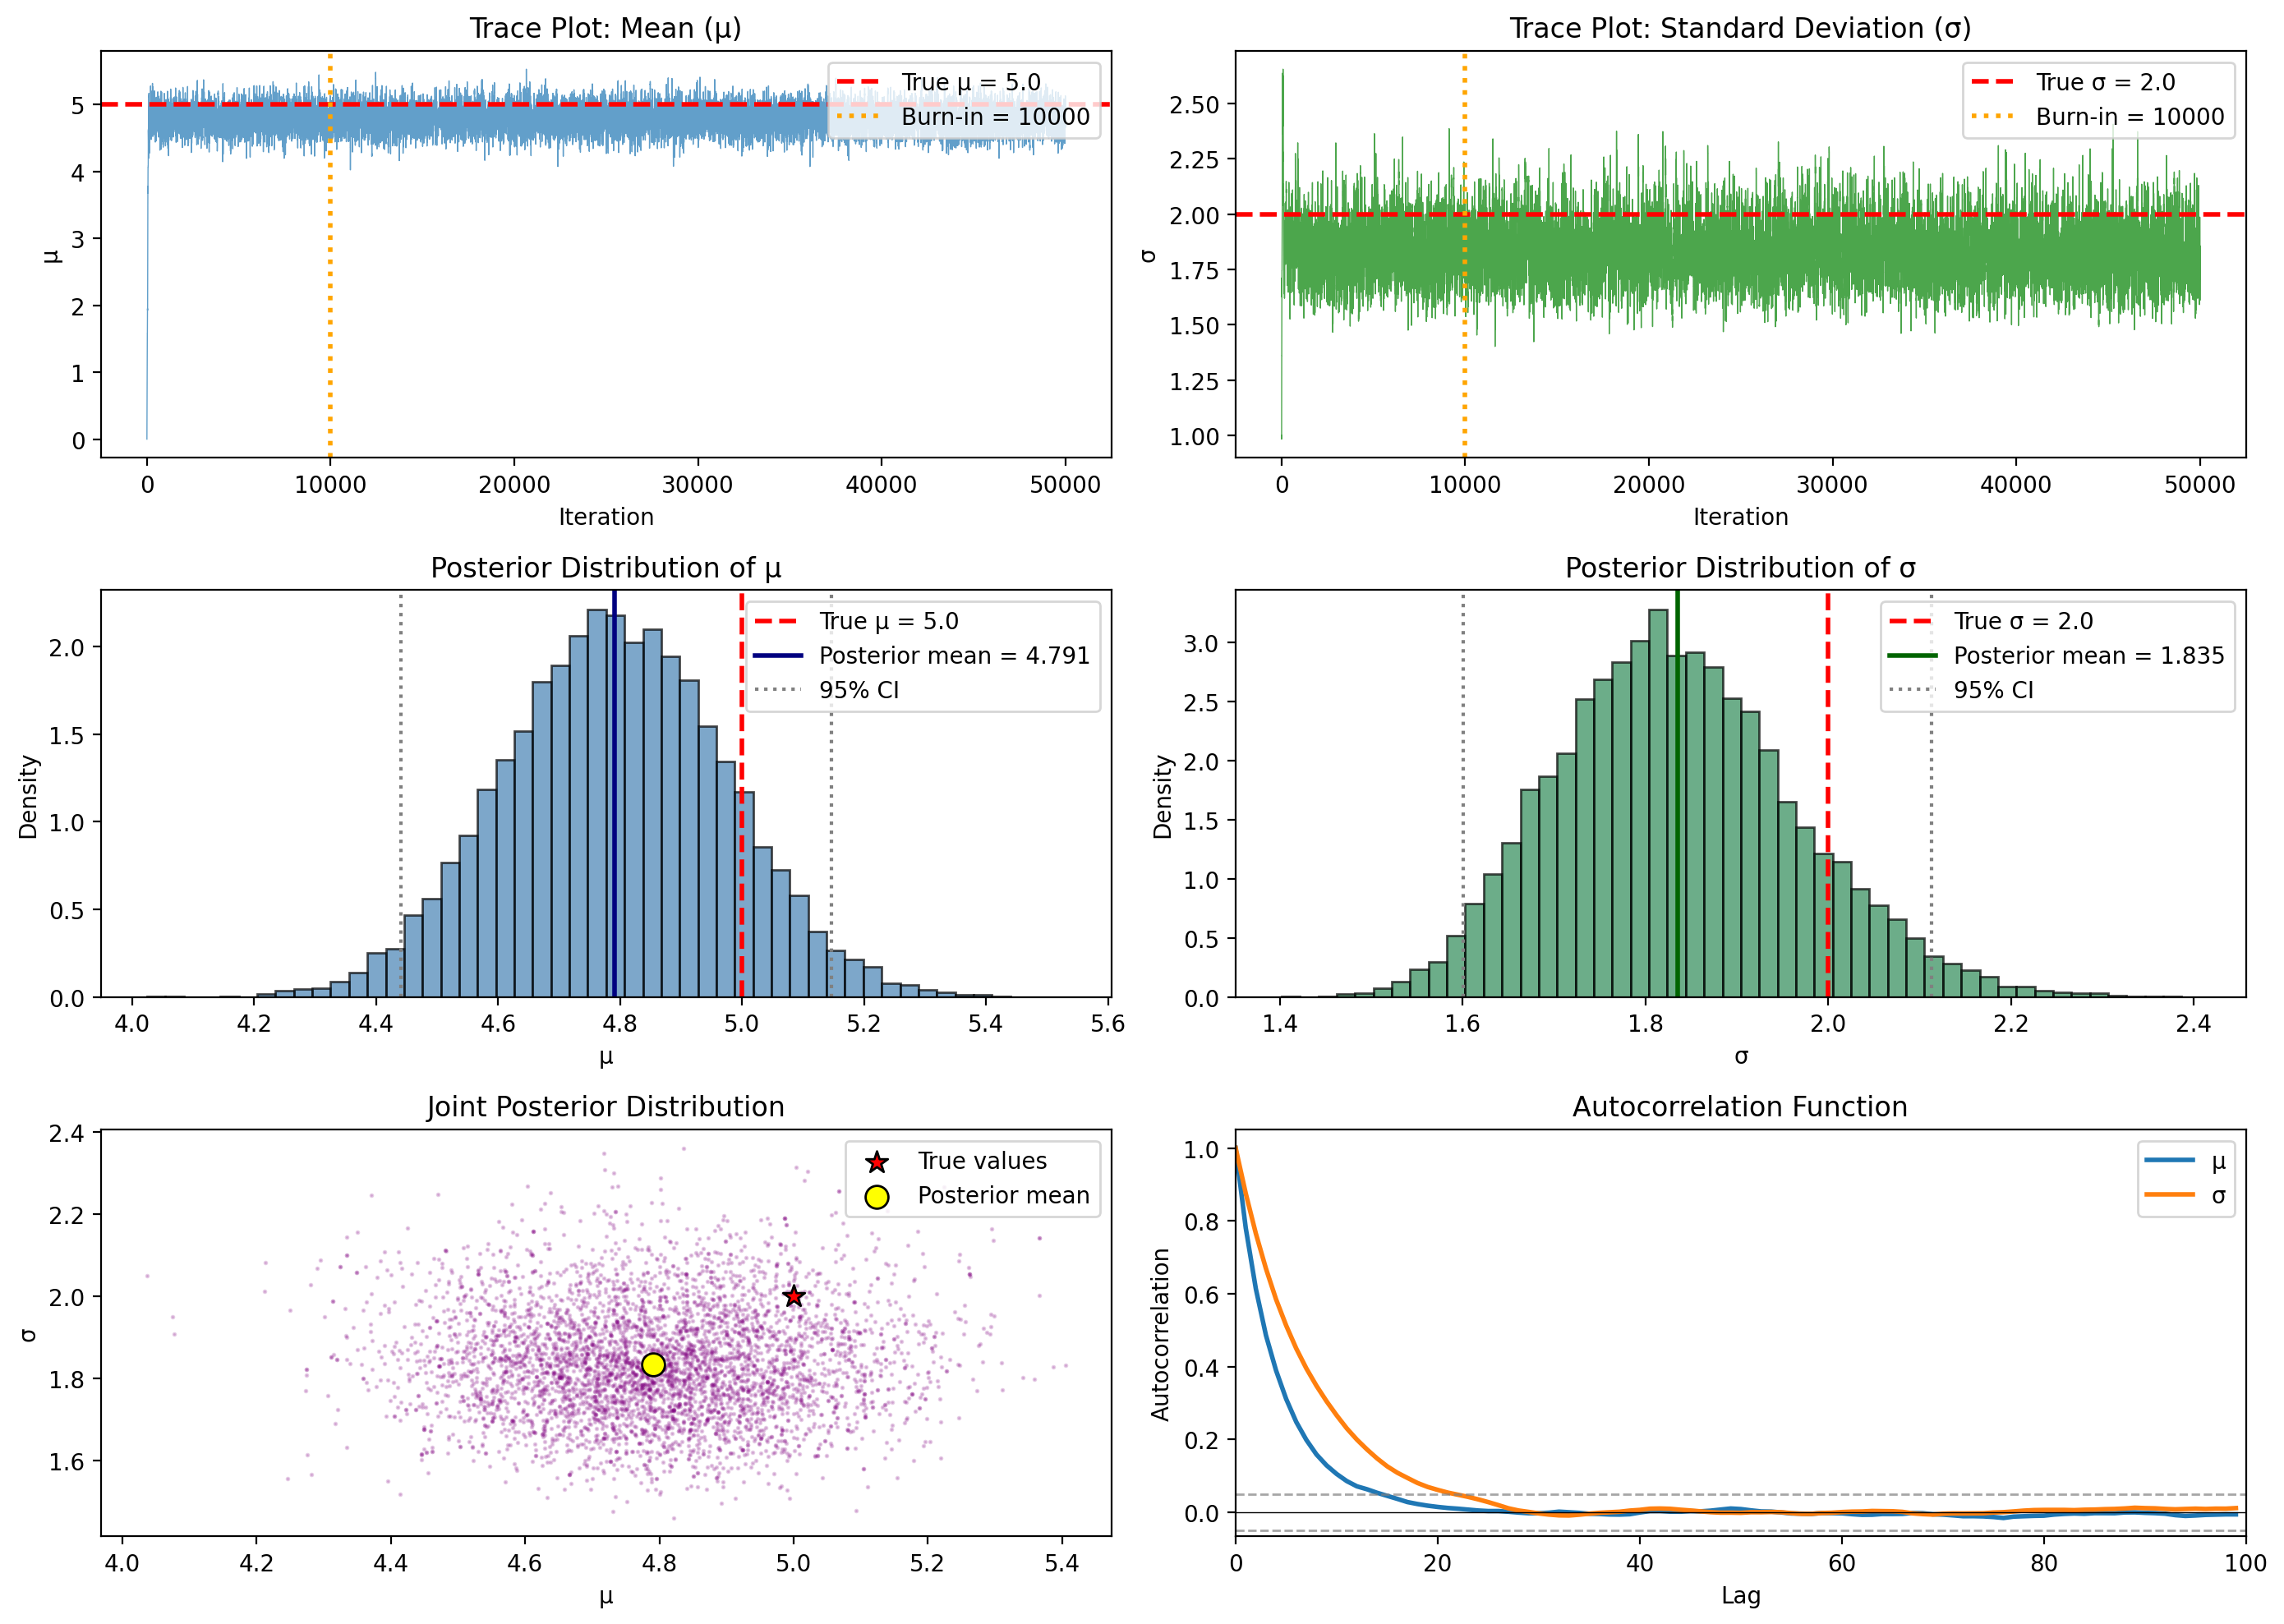


Figure saved to 'plot.png'


In [6]:
# Create comprehensive visualization
fig = plt.figure(figsize=(14, 10))

# 1. Trace plot for μ
ax1 = fig.add_subplot(3, 2, 1)
ax1.plot(samples[:, 0], alpha=0.7, linewidth=0.5)
ax1.axhline(true_mu, color='red', linestyle='--', linewidth=2, label=f'True μ = {true_mu}')
ax1.axvline(burn_in, color='orange', linestyle=':', linewidth=2, label=f'Burn-in = {burn_in}')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('μ')
ax1.set_title('Trace Plot: Mean (μ)')
ax1.legend(loc='upper right')

# 2. Trace plot for σ
ax2 = fig.add_subplot(3, 2, 2)
ax2.plot(samples[:, 1], alpha=0.7, linewidth=0.5, color='green')
ax2.axhline(true_sigma, color='red', linestyle='--', linewidth=2, label=f'True σ = {true_sigma}')
ax2.axvline(burn_in, color='orange', linestyle=':', linewidth=2, label=f'Burn-in = {burn_in}')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('σ')
ax2.set_title('Trace Plot: Standard Deviation (σ)')
ax2.legend(loc='upper right')

# 3. Posterior histogram for μ
ax3 = fig.add_subplot(3, 2, 3)
ax3.hist(mu_samples, bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='black')
ax3.axvline(true_mu, color='red', linestyle='--', linewidth=2, label=f'True μ = {true_mu}')
ax3.axvline(mu_mean, color='navy', linestyle='-', linewidth=2, label=f'Posterior mean = {mu_mean:.3f}')
ax3.axvline(mu_ci[0], color='gray', linestyle=':', linewidth=1.5)
ax3.axvline(mu_ci[1], color='gray', linestyle=':', linewidth=1.5, label='95% CI')
ax3.set_xlabel('μ')
ax3.set_ylabel('Density')
ax3.set_title('Posterior Distribution of μ')
ax3.legend()

# 4. Posterior histogram for σ
ax4 = fig.add_subplot(3, 2, 4)
ax4.hist(sigma_samples, bins=50, density=True, alpha=0.7, color='seagreen', edgecolor='black')
ax4.axvline(true_sigma, color='red', linestyle='--', linewidth=2, label=f'True σ = {true_sigma}')
ax4.axvline(sigma_mean, color='darkgreen', linestyle='-', linewidth=2, label=f'Posterior mean = {sigma_mean:.3f}')
ax4.axvline(sigma_ci[0], color='gray', linestyle=':', linewidth=1.5)
ax4.axvline(sigma_ci[1], color='gray', linestyle=':', linewidth=1.5, label='95% CI')
ax4.set_xlabel('σ')
ax4.set_ylabel('Density')
ax4.set_title('Posterior Distribution of σ')
ax4.legend()

# 5. Joint posterior (2D scatter/density)
ax5 = fig.add_subplot(3, 2, 5)
# Subsample for visualization
subsample_idx = np.random.choice(len(mu_samples), size=min(5000, len(mu_samples)), replace=False)
ax5.scatter(mu_samples[subsample_idx], sigma_samples[subsample_idx], 
           alpha=0.2, s=1, c='purple')
ax5.scatter([true_mu], [true_sigma], color='red', s=100, marker='*', 
           edgecolors='black', linewidths=1, label='True values', zorder=5)
ax5.scatter([mu_mean], [sigma_mean], color='yellow', s=100, marker='o',
           edgecolors='black', linewidths=1, label='Posterior mean', zorder=5)
ax5.set_xlabel('μ')
ax5.set_ylabel('σ')
ax5.set_title('Joint Posterior Distribution')
ax5.legend(loc='upper right')

# 6. Autocorrelation plot
ax6 = fig.add_subplot(3, 2, 6)
max_lag = 100
lags = np.arange(max_lag)
acf_mu = [np.corrcoef(mu_samples[:-lag] if lag > 0 else mu_samples, 
                       mu_samples[lag:] if lag > 0 else mu_samples)[0, 1] 
          for lag in lags]
acf_sigma = [np.corrcoef(sigma_samples[:-lag] if lag > 0 else sigma_samples,
                          sigma_samples[lag:] if lag > 0 else sigma_samples)[0, 1]
             for lag in lags]

ax6.plot(lags, acf_mu, label='μ', linewidth=2)
ax6.plot(lags, acf_sigma, label='σ', linewidth=2)
ax6.axhline(0, color='black', linewidth=0.5)
ax6.axhline(0.05, color='gray', linestyle='--', linewidth=1, alpha=0.7)
ax6.axhline(-0.05, color='gray', linestyle='--', linewidth=1, alpha=0.7)
ax6.set_xlabel('Lag')
ax6.set_ylabel('Autocorrelation')
ax6.set_title('Autocorrelation Function')
ax6.legend()
ax6.set_xlim(0, max_lag)

plt.tight_layout()
plt.savefig('bayesian_inference_mcmc_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved to 'plot.png'")

## Diagnostics and Convergence Assessment

### Effective Sample Size (ESS)

The effective sample size accounts for autocorrelation in the MCMC chain:

$$\text{ESS} = \frac{N}{1 + 2\sum_{k=1}^{\infty} \rho_k}$$

where $\rho_k$ is the autocorrelation at lag $k$.

In [7]:
def effective_sample_size(samples, max_lag=None):
    """
    Estimate the effective sample size of MCMC samples.
    Uses the initial positive sequence estimator.
    """
    n = len(samples)
    if max_lag is None:
        max_lag = n // 2
    
    # Compute autocorrelations
    samples_centered = samples - np.mean(samples)
    acf = np.correlate(samples_centered, samples_centered, mode='full')
    acf = acf[n-1:n-1+max_lag] / acf[n-1]
    
    # Find first negative autocorrelation (initial positive sequence)
    negative_idx = np.where(acf < 0)[0]
    if len(negative_idx) > 0:
        cutoff = negative_idx[0]
    else:
        cutoff = max_lag
    
    # ESS estimate
    tau = 1 + 2 * np.sum(acf[1:cutoff])
    ess = n / tau
    
    return ess

ess_mu = effective_sample_size(mu_samples)
ess_sigma = effective_sample_size(sigma_samples)

print("Effective Sample Size (ESS)")
print("=" * 40)
print(f"Total post burn-in samples: {len(mu_samples)}")
print(f"ESS for μ: {ess_mu:.1f}")
print(f"ESS for σ: {ess_sigma:.1f}")
print(f"\nEfficiency (ESS/N):")
print(f"  μ: {ess_mu/len(mu_samples)*100:.1f}%")
print(f"  σ: {ess_sigma/len(sigma_samples)*100:.1f}%")

Effective Sample Size (ESS)
Total post burn-in samples: 40000
ESS for μ: 4535.1
ESS for σ: 2772.7

Efficiency (ESS/N):
  μ: 11.3%
  σ: 6.9%


## Posterior Predictive Check

A crucial validation step is comparing the posterior predictive distribution with the observed data:

$$p(\tilde{x} | D) = \int p(\tilde{x} | \theta) p(\theta | D) d\theta$$

We approximate this by sampling from the posterior and generating predictions.

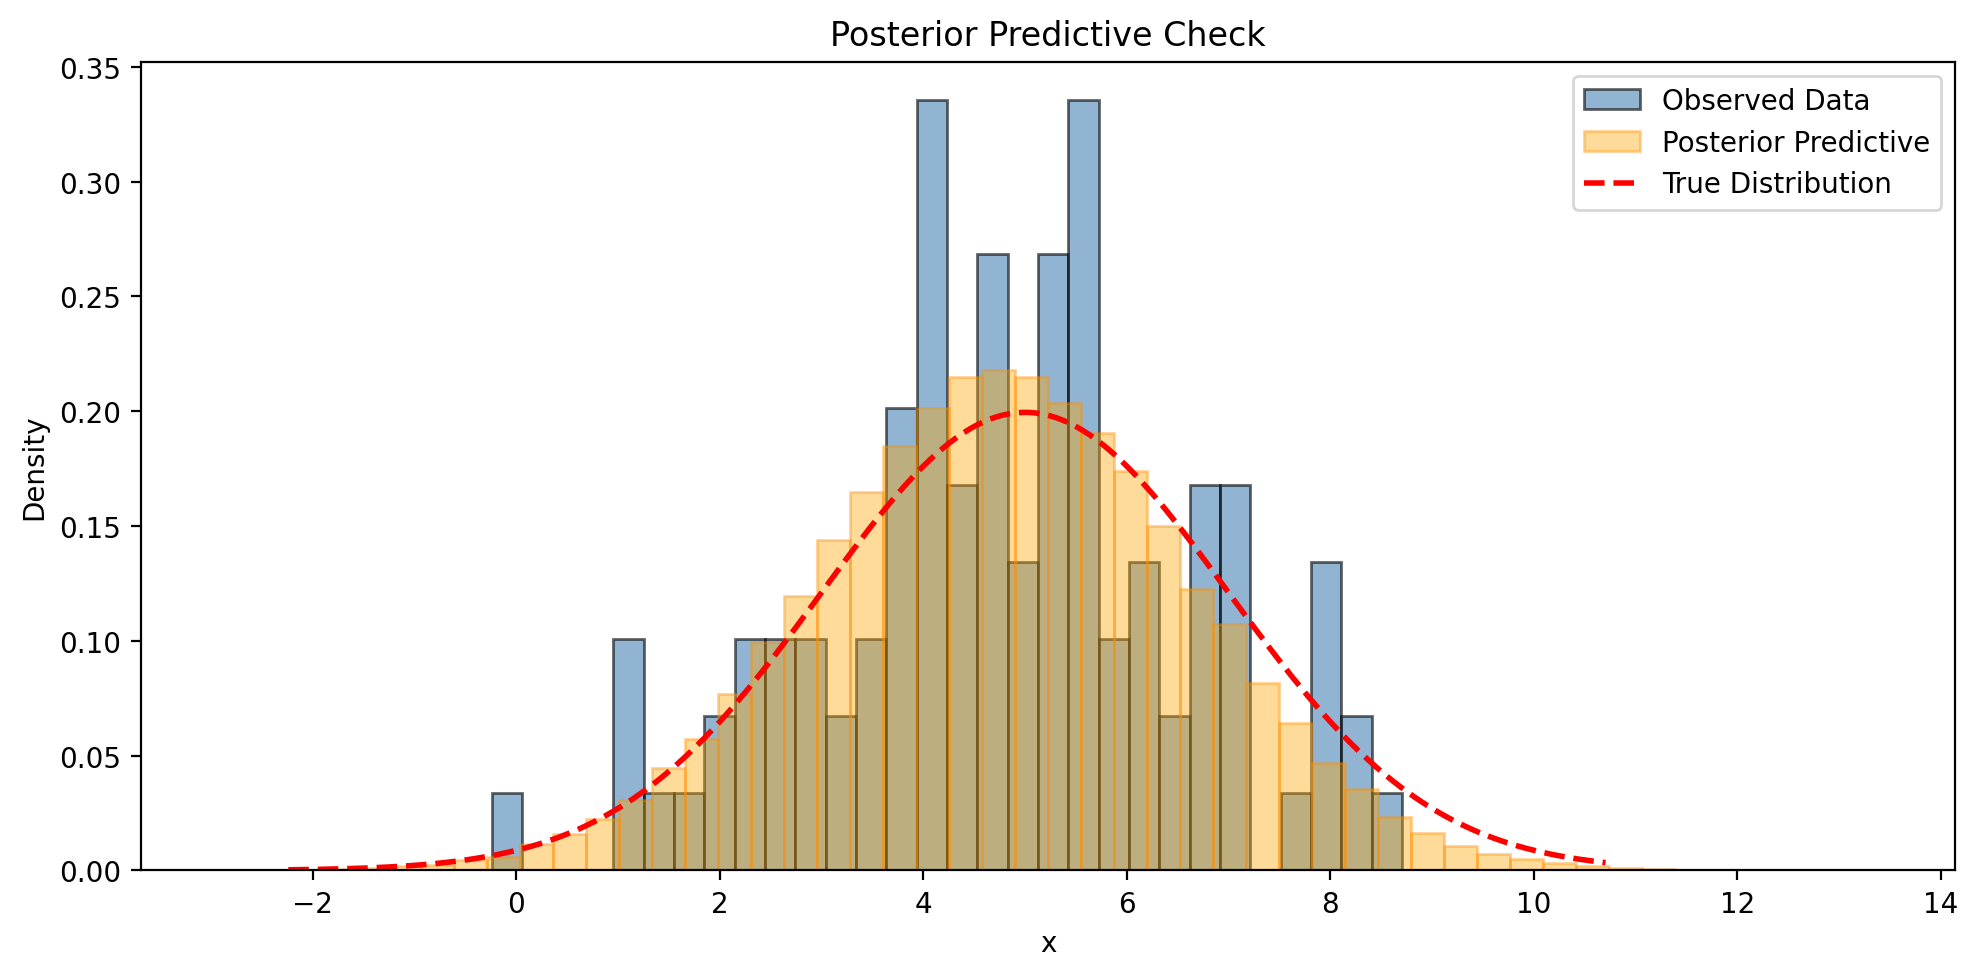

Posterior predictive check complete.
Observed data mean: 4.792, Posterior predictive mean: 4.782
Observed data std: 1.807, Posterior predictive std: 1.851


In [8]:
# Posterior predictive sampling
n_posterior_samples = 1000
n_predictions = 100

# Randomly select posterior samples
idx = np.random.choice(len(mu_samples), size=n_posterior_samples, replace=False)
posterior_predictive = np.zeros((n_posterior_samples, n_predictions))

for i, j in enumerate(idx):
    posterior_predictive[i] = np.random.normal(mu_samples[j], sigma_samples[j], n_predictions)

# Flatten for comparison
pp_samples = posterior_predictive.flatten()

# Plot comparison
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(data, bins=30, density=True, alpha=0.6, color='steelblue', 
        edgecolor='black', label='Observed Data')
ax.hist(pp_samples, bins=50, density=True, alpha=0.4, color='orange',
        edgecolor='darkorange', label='Posterior Predictive')

# True distribution
x_grid = np.linspace(data.min() - 2, data.max() + 2, 200)
ax.plot(x_grid, stats.norm.pdf(x_grid, true_mu, true_sigma), 
       'r--', linewidth=2, label='True Distribution')

ax.set_xlabel('x')
ax.set_ylabel('Density')
ax.set_title('Posterior Predictive Check')
ax.legend()

plt.tight_layout()
plt.show()

print("Posterior predictive check complete.")
print(f"Observed data mean: {data.mean():.3f}, Posterior predictive mean: {pp_samples.mean():.3f}")
print(f"Observed data std: {data.std():.3f}, Posterior predictive std: {pp_samples.std():.3f}")

## Conclusion

This notebook demonstrated the fundamentals of **Bayesian inference using Markov Chain Monte Carlo (MCMC)**:

1. **Bayes' theorem** provides the theoretical foundation for updating beliefs given data
2. **Metropolis-Hastings** algorithm enables sampling from complex posterior distributions
3. **Convergence diagnostics** (trace plots, ESS, autocorrelation) ensure reliable inference
4. **Posterior predictive checks** validate model fit

### Key Takeaways

- MCMC methods bypass the need to compute intractable normalizing constants
- Proposal distribution tuning affects acceptance rate and mixing efficiency
- Burn-in period is essential to discard samples before convergence
- The posterior distribution fully characterizes parameter uncertainty

### Further Reading

- Gelman, A., et al. (2013). *Bayesian Data Analysis*, 3rd ed.
- Brooks, S., et al. (2011). *Handbook of Markov Chain Monte Carlo*
- Robert, C. & Casella, G. (2004). *Monte Carlo Statistical Methods*